In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import random as rand
import sys
from scipy.stats import norm
import math

# Stocks and Hedges

In [2]:
class stock:
    def __init__(self, dt, T, Scur, mu, sigma, strike_price):
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.N = math.ceil(T/dt)
        self.T = self.N*dt
        self.N += 1
        self.Scur = Scur
        self.Tcur = 0.0
        self.K = strike_price
        
        #tests:
#         self.counter = 0
#         self.stock_list = [self.Scur,48.12,47.37,50.25,51.75,53.12,53.00,51.87,51.38,53.00,49.88,48.50,49.88,50.37,52.13,51.88,52.87,54.87,54.62,55.87,57.25]
#         self.stock_list = [self.Scur,48.12,47.37,50.25,51.75,53.12,53.00,51.87,51.38,53.00,49.88,48.50,49.88,50.37,52.13,51.88,52.87,54.87,54.62,55.87,52]
        
    def update_mu(self,new_mu):
        self.mu = new_mu
    def update_sigma(self,new_sigma):
        self.sigma = new_sigma
        
    def sample(self): #probably not needed
        eps = rand.normal(0,1)
        return Scur*(1 + self.mu*Tcur + self.sigma*eps*np.sqrt(dt))
    def step(self):
        eps = rand.normal(0,1)
        self.Tcur += dt
        self.Scur = self.Scur*(1 + self.mu*self.Tcur + self.sigma*eps*np.sqrt(dt))
#         self.counter+=1
#         if self.counter < self.N:
#             self.Scur = self.stock_list[self.counter]
# #             print(self.counter,self.Scur)
        return self.Scur    
        

In [270]:
class delta_hedge_process:
    def long_call_hedge(self,stock):
        S = stock.Scur
        K = stock.K
        tau = stock.T - stock.Tcur
        sigma = stock.sigma
        r = self.risk_free
        d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
        return norm.cdf(d_plus)
    def NEW_LCH(self,stock):
        S = stock.Scur
        K = stock.K
        tau = stock.T - stock.Tcur
        sigma = stock.sigma
        r = self.risk_free
        d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
        d_minus = d_plus - sigma*np.sqrt(tau)
        C = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
        return C/S
    def Mixed_invT(self,stock,Reg=0.1):
        sigma = stock.sigma
        t = stock.T - stock.Tcur
        r = self.risk_free
        S = stock.Scur
        K = stock.K
        d_plus = (1/(sigma*np.sqrt(t)))*( np.log(S/K) + (r + sigma*sigma/2)*t )
        d_minus = d_plus - sigma*np.sqrt(t)
        Reg = K*sigma*sigma*.1/t
        e = Reg/10
        in_Reg = 0.5*(1 + np.tanh((S - (K - Reg/2)) / e))
        out_Reg = 0.5*(1 - np.tanh((S - (K + Reg/2)) / e))
        window = in_Reg*out_Reg
        
        LCH = norm.cdf(d_plus)
        C = S*norm.cdf(d_plus) - K*np.exp(-r*t)*norm.cdf(d_minus)
        NEW_LCH = C/S
        return (1-window)*LCH + window*NEW_LCH
    def Mixed_theta(self,stock,Reg=0.1):
        sigma = stock.sigma
        t = stock.T - stock.Tcur
        r = self.risk_free
        S = stock.Scur
        K = stock.K
        d_plus = (1/(sigma*np.sqrt(t)))*( np.log(S/K) + (r + sigma*sigma/2)*t )
        d_minus = d_plus - sigma*np.sqrt(t)
        theta = (-S*norm.pdf(d_plus)*sigma/(2*np.sqrt(t)) - r*K*np.exp(-r*t)*norm.cdf(d_minus)) + 1e-16
        Reg = np.abs(theta)/(sigma*sigma)
        e = Reg/10
        in_Reg = 0.5*(1 + np.tanh((S - (K - Reg/2)) / e))
        out_Reg = 0.5*(1 - np.tanh((S - (K + Reg/2)) / e))
        window = in_Reg*out_Reg
        
        LCH = norm.cdf(d_plus)
        C = S*norm.cdf(d_plus) - K*np.exp(-r*t)*norm.cdf(d_minus)
        NEW_LCH = C/S
        return (1-window)*LCH + window*NEW_LCH
    def Mixed_constant(self,stock,Reg=0.1):
        sigma = stock.sigma
        t = stock.T - stock.Tcur
        r = self.risk_free
        S = stock.Scur
        K = stock.K
        d_plus = (1/(sigma*np.sqrt(t)))*( np.log(S/K) + (r + sigma*sigma/2)*t )
        d_minus = d_plus - sigma*np.sqrt(t)
        Reg *= K
        e = Reg/10
        in_Reg = 0.5*(1 + np.tanh((S - (K - Reg/2)) / e))
        out_Reg = 0.5*(1 - np.tanh((S - (K + Reg/2)) / e))
        window = in_Reg*out_Reg
        
        LCH = norm.cdf(d_plus)
        C = S*norm.cdf(d_plus) - K*np.exp(-r*t)*norm.cdf(d_minus)
        NEW_LCH = C/S
        return (1-window)*LCH + window*NEW_LCH
    def Mixed_gamma_theta(self,stock,Reg=0.1):
        sigma = stock.sigma
        t = stock.T - stock.Tcur
        r = self.risk_free
        S = stock.Scur
        K = stock.K
        d_plus = (1/(sigma*np.sqrt(t)))*( np.log(S/K) + (r + sigma*sigma/2)*t )
        d_minus = d_plus - sigma*np.sqrt(t)
        theta = (-S*norm.pdf(d_plus)*sigma/(2*np.sqrt(t)) - r*K*np.exp(-r*t)*norm.cdf(d_minus))
        gamma = norm.pdf(d_plus)/(S*sigma*np.sqrt(t))
        gt = gamma*np.abs(theta)
        
        d_plusK = (1/(sigma*np.sqrt(t)))*(r + sigma*sigma/2)*t
        d_minusK = d_plus - sigma*np.sqrt(t)
        thetaK = (-K*norm.pdf(d_plus)*sigma/(2*np.sqrt(t)) - r*K*np.exp(-r*t)*norm.cdf(d_minus))
        gammaK = norm.pdf(d_plus)/(K*sigma*np.sqrt(t))
        gtK = gammaK*np.abs(thetaK)
        
        gamma_norm = 1. if gtK==0 else gt/gtK
        
        window = gamma_norm

        LCH = norm.cdf(d_plus)
        C = S*norm.cdf(d_plus) - K*np.exp(-r*t)*norm.cdf(d_minus)
        NEW_LCH = C/S
        return (1-window)*LCH + window*NEW_LCH
        
    def __init__(self, hedge_types, rfRate, stock_args, contracts=1):
    # all functions above should have a place in this dictionary
        self.hedge_dict = {"long call":self.long_call_hedge,"new long call":self.NEW_LCH,
                           "mixed-theta":self.Mixed_theta,"mixed-invT":self.Mixed_invT,
                           "mixed-constant":self.Mixed_constant,"mixed-gammatheta":self.Mixed_gamma_theta}
        
    # All time should be given in units of years
        self.risk_free = rfRate
        self.r_eff = rfRate*dt
        self.stock = stock(*stock_args)
        self.num_of_contracts = contracts 
        
        self.hedge_types = hedge_types
        self.hedges_to_do = [self.hedge_dict[hedge] for hedge in hedge_types]
        self.FINAL_PRICE = [0 for i in range(len(hedge_types))]
        
    def process_to_maturity(self):
        num_of_hedge_types = len(self.hedges_to_do)
        S_of_t = []
        cost_of_t = [[] for i in range(num_of_hedge_types)]
        cumul_cost_of_t = [[] for i in range(num_of_hedge_types)]
        loan_of_t = [[] for i in range(num_of_hedge_types)]
        interest_of_t = [[] for i in range(num_of_hedge_types)]
        shares_of_t = [[] for i in range(num_of_hedge_types)]
        cumul_shares_of_t = [[] for i in range(num_of_hedge_types)]
        
        shares = [0 for i in range(num_of_hedge_types)]
        cumul_shares = [0 for i in range(num_of_hedge_types)]
        interest = [0 for i in range(num_of_hedge_types)]
        cost = [0 for i in range(num_of_hedge_types)]
        cumul_cost = [0 for i in range(num_of_hedge_types)]
        
        for i in range(self.stock.N):
            S = self.stock.Scur
            S_of_t.append(S)
            for j in range(num_of_hedge_types):
                delta = self.hedges_to_do[j](self.stock)
                shares[j] = delta - cumul_shares[j]
                cumul_shares[j] += shares[j]
                cost[j] = shares[j]*S
                cumul_cost[j] += cost[j] + interest[j]
                
                if cumul_cost[j]>0.0:
                    interest[j] = cumul_cost[j]*self.r_eff
                    
                shares_of_t[j].append(shares[j])
                cumul_shares_of_t[j].append(cumul_shares[j])
                cost_of_t[j].append(cost[j])
                cumul_cost_of_t[j].append(cumul_cost[j])
                interest_of_t[j].append(interest[j])
                
            self.stock.step()
            
        for j in range(num_of_hedge_types):
#             final_sell = -S_of_t[-1]*cumul_shares_of_t[j][-1]
#             cost_of_t[j].append(final_sell)
#             cumul_cost_of_t[j].append(cumul_cost_of_t[j][-1]+final_sell)
            
            if cumul_shares_of_t[j][-1]==1:
                self.FINAL_PRICE[j] = cumul_cost_of_t[j][-1] - self.stock.K
            else:
                self.FINAL_PRICE[j] = cumul_cost_of_t[j][-1]
            
        return S_of_t, cost_of_t, cumul_cost_of_t, shares_of_t, cumul_shares_of_t, interest_of_t

# Running:

In [279]:
Scur = 49
strike_price = 50
rfRate = 0.05
sigma = 0.05
T = 20./52.
dt = 1./52.
mu = 0.
stock_args = (dt, T, Scur, mu, sigma, strike_price)

hedge_types = ["long call","new long call","mixed-theta","mixed-invT","mixed-constant","mixed-gammatheta"]
my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

In [280]:
S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()

In [281]:
my_delta_hedge.FINAL_PRICE

[0.7736125930512594,
 0.01919139259286247,
 0.019265567212472377,
 0.7736125930512594,
 0.018532344901868603,
 0.021068695616505404]

In [24]:
def auto_subplots(n, **kwargs):
    cols = math.ceil(math.sqrt(n))
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, **kwargs)
    axes = axes.flatten() if n > 1 else [axes]
    return fig, axes[:n]

# Comparing Hedging Methods Statistically

## small variance

In [282]:
S = 50
K = 50
tau = 20./52.
sigma = 0.05
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  1.202956651115926


In [283]:
hedge_types = ["long call","new long call","mixed-theta","mixed-invT","mixed-constant","mixed-gammatheta"]
costs = [[] for _ in range(len(hedge_types))]
for i in range(10000):
    Scur = 50
    strike_price = 50
    rfRate = 0.05
    sigma = 0.05
    T = 20./52.
    dt = 1./52.
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
    for i,price in enumerate(final_prices):
        costs[i].append(price)
    
# traditional_cost = np.array(traditional_cost)
# my_cost = np.array(my_cost)
costs = np.array(costs)
print("Averages: ",np.mean(costs,axis=1))
print("Variances: ",np.var(costs,axis=1))

Averages:  [1.23116334 0.62978652 0.63207405 1.17425645 3.69988141 0.63498328]
Variances:  [1.34886896e-02 7.90500390e-01 7.93132577e-01 1.10165098e-01
 1.11630693e+02 7.78254722e-01]


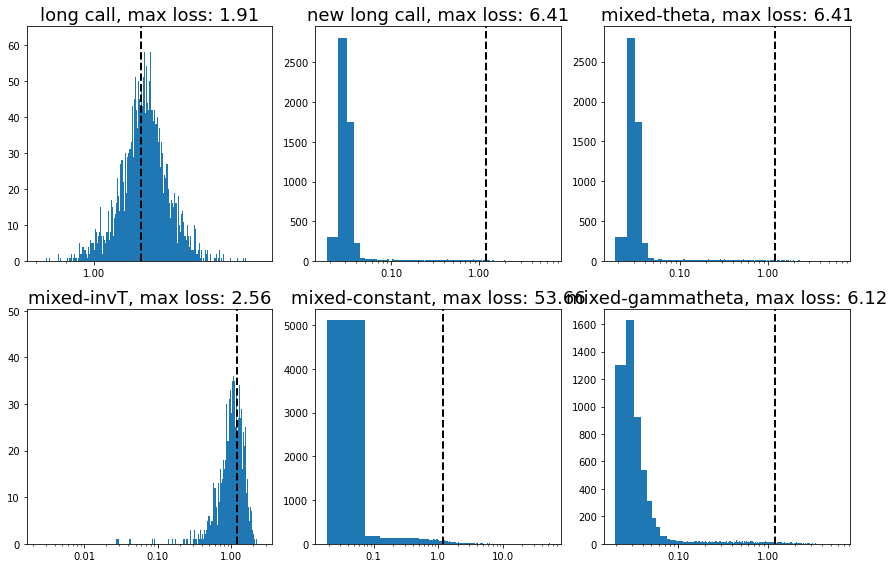

In [284]:
from matplotlib.ticker import ScalarFormatter
fig, axs = auto_subplots(len(hedge_types),figsize=(12,8))
bins = 1000

for i,ax in enumerate(axs):
    ax.hist(costs[i], bins=bins)
    ax.axvline(BS_price,color='k',linestyle="--",linewidth=2)
    
    max_loss = np.amax(costs[i])
    ax.set_title(hedge_types[i]+", max loss: {:.2f}".format(max_loss),fontsize=18)
    if i!=0 or i!=3:
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(ScalarFormatter())
fig.tight_layout()
# ax2.axvline(BS_price,color='k',linestyle="--",linewidth=2)
# ax2.xaxis.set_ticks([0.0,0.05,0.1,0.5,1.0,2,5,10])
# ax2.set_xticks([0.0,0.05,0.1,0.5,1.0,2.0]) 
# ax2.set_xticklabels([0.0,0.05,0.1,0.5,1.0,2.0], fontsize=12)


## large variance

In [285]:
S = 50
K = 50
tau = 20./52.
sigma = 0.65
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  8.395816815604057


In [286]:
hedge_types = ["long call","new long call","mixed-theta","mixed-invT","mixed-constant","mixed-gammatheta"]
costs = [[] for _ in range(len(hedge_types))]
for i in range(10000):
    Scur = 50
    strike_price = 50
    rfRate = 0.05
    sigma = 0.65
    T = 20./52.
    dt = 1./52.
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
    for i,price in enumerate(final_prices):
        costs[i].append(price)
    
# traditional_cost = np.array(traditional_cost)
# my_cost = np.array(my_cost)
costs = np.array(costs)

print("Averages: ",np.mean(costs,axis=1))
print("Variances: ",np.var(costs,axis=1))

Averages:  [ 8.56771812  8.05696361 16.30667992  8.35390654 15.66825639  8.09745492]
Variances:  [  2.42679249 101.9809855  468.61249439  41.03690006 342.94701313
  87.44307222]


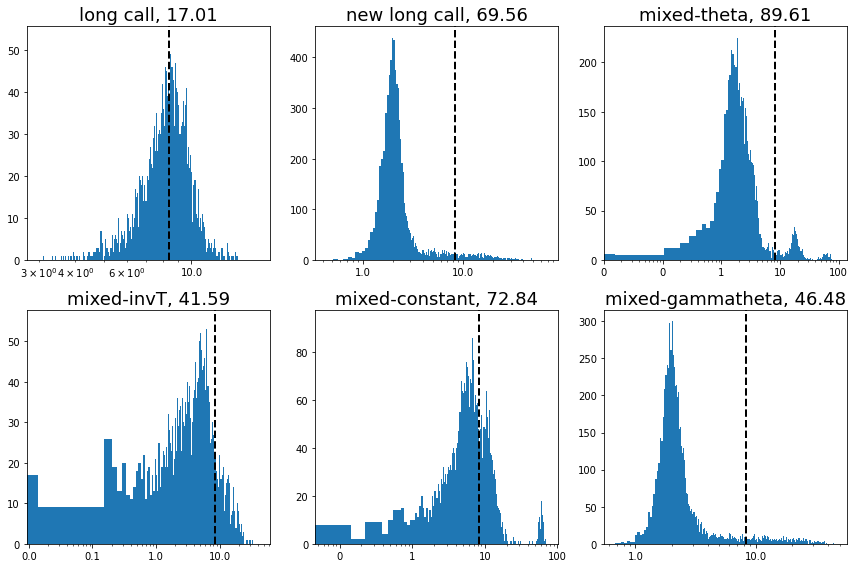

In [287]:
from matplotlib.ticker import ScalarFormatter
fig, axs = auto_subplots(len(hedge_types),figsize=(12,8))
bins = 1000

for i,ax in enumerate(axs):
    ax.hist(costs[i], bins=bins)
    ax.axvline(BS_price,color='k',linestyle="--",linewidth=2)
    
    max_loss = np.amax(costs[i])
    ax.set_title(hedge_types[i]+", {:.2f}".format(max_loss),fontsize=18)
    if i!=0 or i!=3:
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(ScalarFormatter())
fig.tight_layout()
# ax2.axvline(BS_price,color='k',linestyle="--",linewidth=2)
# ax2.xaxis.set_ticks([0.0,0.05,0.1,0.5,1.0,2,5,10])
# ax2.set_xticks([0.0,0.05,0.1,0.5,1.0,2.0]) 
# ax2.set_xticklabels([0.0,0.05,0.1,0.5,1.0,2.0], fontsize=12)


## small variance, lower start price

In [288]:
S = 49
K = 50
tau = 20./52.
sigma = 0.05
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  0.5829072848018519


In [289]:
hedge_types = ["long call","new long call","mixed-theta","mixed-invT","mixed-constant","mixed-gammatheta"]
costs = [[] for _ in range(len(hedge_types))]
for i in range(10000):
    Scur = 49
    strike_price = 50
    rfRate = 0.05
    sigma = 0.05
    T = 20./52.
    dt = 1./52.
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
    for i,price in enumerate(final_prices):
        costs[i].append(price)
    
# traditional_cost = np.array(traditional_cost)
# my_cost = np.array(my_cost)
costs = np.array(costs)

print("Averages: ",np.mean(costs,axis=1))
print("Variances: ",np.var(costs,axis=1))

Averages:  [0.59977322 0.24109933 0.24226275 0.58402863 1.05768255 0.24058164]
Variances:  [1.27741869e-02 3.12220097e-01 3.13732352e-01 3.17020774e-02
 2.97395841e+01 3.10700562e-01]


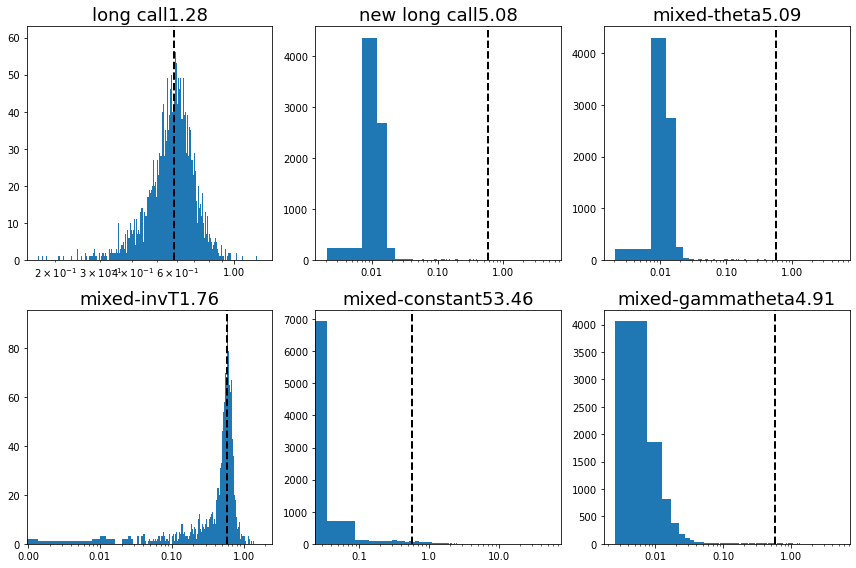

In [290]:
from matplotlib.ticker import ScalarFormatter
fig, axs = auto_subplots(len(hedge_types),figsize=(12,8))
bins = 1000

for i,ax in enumerate(axs):
    ax.hist(costs[i], bins=bins)
    ax.axvline(BS_price,color='k',linestyle="--",linewidth=2)
    
    max_loss = np.amax(costs[i])
    ax.set_title(hedge_types[i]+" {:.2f}".format(max_loss),fontsize=18)
    if i!=0 or i!=3:
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(ScalarFormatter())
fig.tight_layout()


## small variance, higher start price

In [291]:
S = 51
K = 50
tau = 20./52.
sigma = 0.05
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  2.029370376192851


In [292]:
hedge_types = ["long call","new long call","mixed-theta","mixed-invT","mixed-constant","mixed-gammatheta"]
costs = [[] for _ in range(len(hedge_types))]
for i in range(10000):
    Scur = 51
    strike_price = 50
    rfRate = 0.05
    sigma = 0.05
    T = 20./52.
    dt = 1./52.
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
   
    for i,price in enumerate(final_prices):
        costs[i].append(price)
    
# traditional_cost = np.array(traditional_cost)
# my_cost = np.array(my_cost)
costs = np.array(costs)

print("Averages: ",np.mean(costs,axis=1))
print("Variances: ",np.var(costs,axis=1))

Averages:  [ 2.07422653  1.27313353  1.27652418  2.06136221 10.33507735  1.29100607]
Variances:  [9.33062480e-03 1.46864239e+00 1.47134860e+00 2.94523028e-02
 3.03269561e+02 1.41473999e+00]


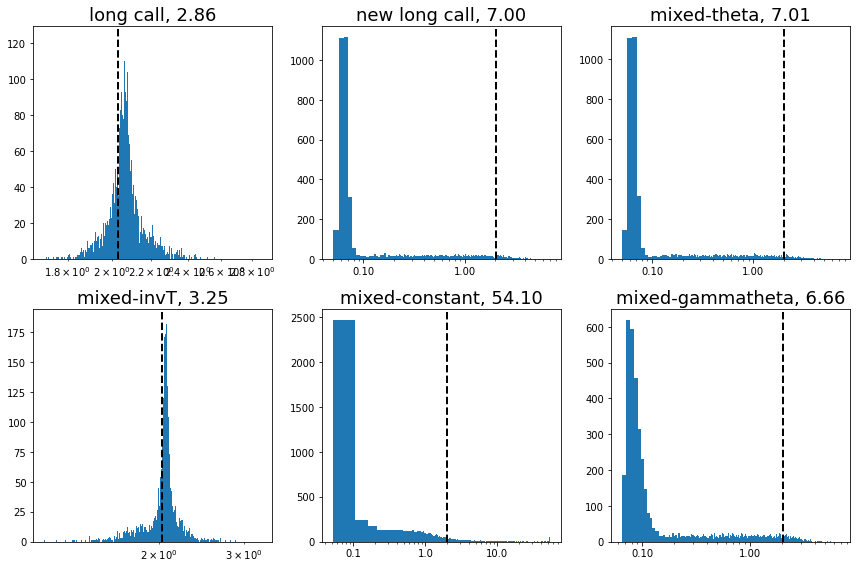

In [293]:
from matplotlib.ticker import ScalarFormatter
fig, axs = auto_subplots(len(hedge_types),figsize=(12,8))
bins = 1000

for i,ax in enumerate(axs):
    ax.hist(costs[i], bins=bins)
    ax.axvline(BS_price,color='k',linestyle="--",linewidth=2)
    
    max_loss = np.amax(costs[i])
    ax.set_title(hedge_types[i]+", {:.2f}".format(max_loss),fontsize=18)
    if i!=0 or i!=3:
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(ScalarFormatter())
fig.tight_layout()


## high variance, lower start price

In [294]:
S = 49
K = 50
tau = 20./52.
sigma = 0.65
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  7.807092508425786


In [295]:
hedge_types = ["long call","new long call","mixed-theta","mixed-invT","mixed-constant","mixed-gammatheta"]
costs = [[] for _ in range(len(hedge_types))]
for i in range(10000):
    Scur = 49
    strike_price = 50
    rfRate = 0.05
    sigma = 0.65
    T = 20./52.
    dt = 1./52.
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE

    for i,price in enumerate(final_prices):
        costs[i].append(price)
    
# traditional_cost = np.array(traditional_cost)
# my_cost = np.array(my_cost)
costs = np.array(costs)

print("Averages: ",np.mean(costs,axis=1))
print("Variances: ",np.var(costs,axis=1))

Averages:  [ 7.98066038  7.58305209 15.34414953  7.73498235 14.60235334  7.6120588 ]
Variances:  [  2.35684393  99.93270513 455.545375    39.42816264 329.1300849
  85.37059831]


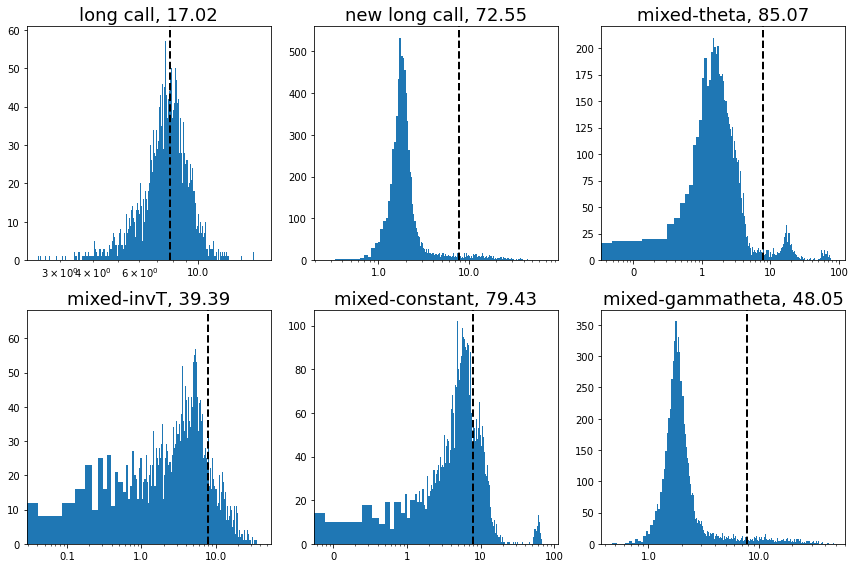

In [296]:
from matplotlib.ticker import ScalarFormatter
fig, axs = auto_subplots(len(hedge_types),figsize=(12,8))
bins = 1000

for i,ax in enumerate(axs):
    ax.hist(costs[i], bins=bins)
    ax.axvline(BS_price,color='k',linestyle="--",linewidth=2)
    
    max_loss = np.amax(costs[i])
    ax.set_title(hedge_types[i]+", {:.2f}".format(max_loss),fontsize=18)
    if i!=0 or i!=3:
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(ScalarFormatter())
fig.tight_layout()

## high variance, higher start price

In [297]:
S = 51
K = 50
tau = 20./52.
sigma = 0.65
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  9.00372754061058


In [298]:
hedge_types = ["long call","new long call","mixed-theta","mixed-invT","mixed-constant","mixed-gammatheta"]
costs = [[] for _ in range(len(hedge_types))]
for i in range(10000):
    Scur = 51
    strike_price = 50
    rfRate = 0.05
    sigma = 0.65
    T = 20./52.
    dt = 1./52.
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
    for i,price in enumerate(final_prices):
        costs[i].append(price)
    
# traditional_cost = np.array(traditional_cost)
# my_cost = np.array(my_cost)
costs = np.array(costs)

print("Averages: ",np.mean(costs,axis=1))
print("Variances: ",np.var(costs,axis=1))

Averages:  [ 9.22328498  8.66225541 16.97363652  9.01392378 16.49951896  8.67673453]
Variances:  [  2.43542378 110.97969959 468.71166468  43.01489413 353.15260342
  93.53135967]


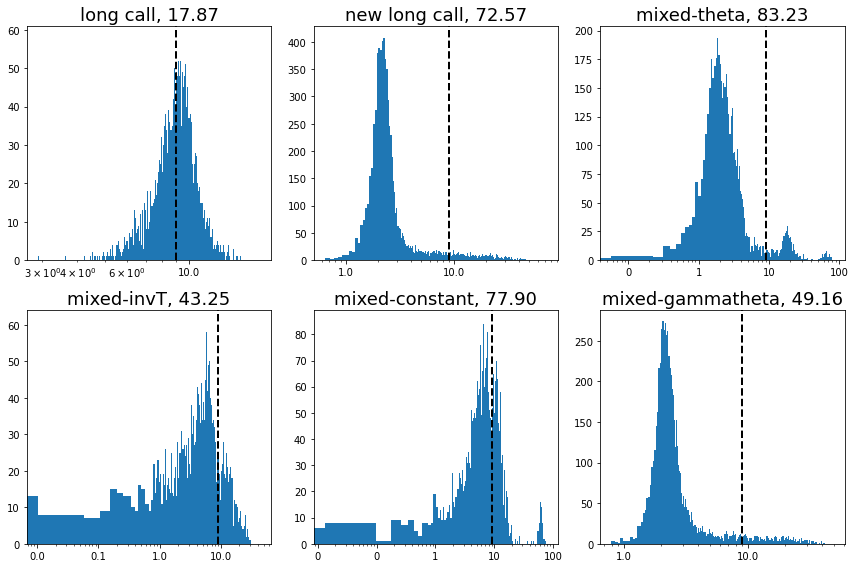

In [299]:
from matplotlib.ticker import ScalarFormatter
fig, axs = auto_subplots(len(hedge_types),figsize=(12,8))
bins = 1000

for i,ax in enumerate(axs):
    ax.hist(costs[i], bins=bins)
    ax.axvline(BS_price,color='k',linestyle="--",linewidth=2)
    
    max_loss = np.amax(costs[i])
    ax.set_title(hedge_types[i]+", {:.2f}".format(max_loss),fontsize=18)
    if i!=0 or i!=3:
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(ScalarFormatter())
fig.tight_layout()


In [ ]:
def integrate_0_to(X,counts,bins):
    if X>=bins[-1]:
        return 1
    integral = 0
    B = bins[0]
    i = 0
    while X > B:
        integral += counts[i]
        i += 1
        B = bins[i]
    integral += counts[i]
    integral /= np.sum(counts)
    return integral

In [ ]:
def integrate_from(a,b,counts,bins):
    if b>bins[-1]:
        b = bins[-1]
    if (b-a)>=bins[-1]:
        return 1
    integral = 0
    B = bins[0]
    i = 0
    while a > B and i < len(bins):
        i += 1
        B = bins[i]
    while b >= B and i < len(counts-1):
        integral += counts[i]
        i += 1
        B = bins[i]
#     integral += counts[i]
    integral /= np.sum(counts)
    return integral

In [ ]:
int1 = integrate_0_to(4.5,counts1,bins1)
print(int1)

In [ ]:
int2 = integrate_0_to(4.5,counts2,bins2)
print(int2)

In [ ]:
delta = BS_price*0.1

In [ ]:
int1 = integrate_from(0,BS_price*1.5,counts1,bins1)
print(int1)

In [ ]:
int2 = integrate_from(0,BS_price*1.5,counts2,bins2)
print(int2)

In [ ]:
BS_price

## More rebalancing

In [300]:
S = 49
K = 50
tau = 20./52.
sigma = 0.5
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  6.016573478964997


In [301]:
hedge_types = ["long call","new long call","mixed-theta","mixed-invT","mixed-constant","mixed-gammatheta"]
costs = [[] for _ in range(len(hedge_types))]
for i in range(10000):
    Scur = 49
    strike_price = 50
    rfRate = 0.05
    sigma = 0.5
    T = 20./52.
    dt = (1./52.)*0.25
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
    for i,price in enumerate(final_prices):
        costs[i].append(price)
    
# traditional_cost = np.array(traditional_cost)
# my_cost = np.array(my_cost)
costs = np.array(costs)

print("Averages: ",np.mean(costs,axis=1))
print("Variances: ",np.var(costs,axis=1))

Averages:  [ 6.13759684  5.72219315 17.18157915  5.98049352 14.52319605  5.74034967]
Variances:  [3.62971017e-01 6.17916628e+01 6.43444726e+02 2.12491544e+01
 3.95687269e+02 5.33536440e+01]


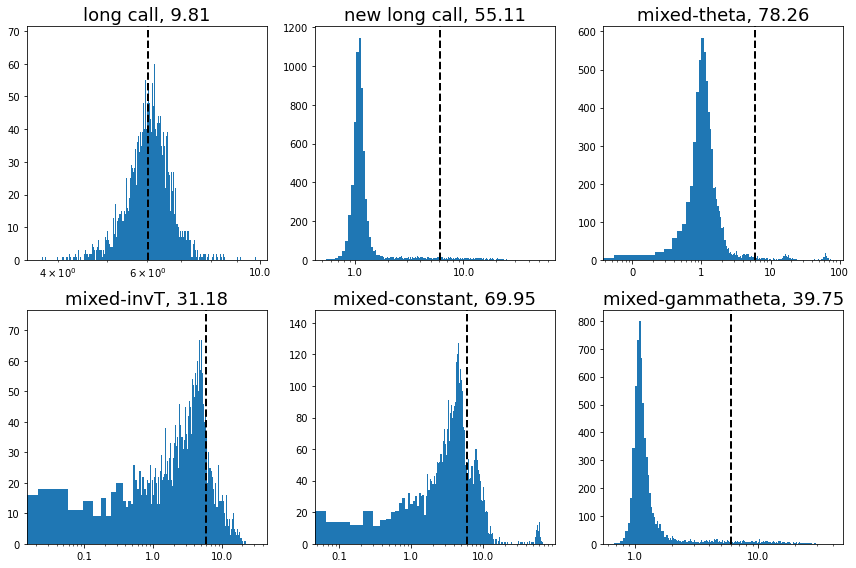

In [302]:
from matplotlib.ticker import ScalarFormatter
fig, axs = auto_subplots(len(hedge_types),figsize=(12,8))
bins = 1000

for i,ax in enumerate(axs):
    ax.hist(costs[i], bins=bins)
    ax.axvline(BS_price,color='k',linestyle="--",linewidth=2)
    
    max_loss = np.amax(costs[i])
    ax.set_title(hedge_types[i]+", {:.2f}".format(max_loss),fontsize=18)
    if i!=0 or i!=3:
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(ScalarFormatter())
fig.tight_layout()

## Less rebalancing

In [303]:
S = 49
K = 50
tau = 20./52.
sigma = 0.5
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  6.016573478964997


In [304]:
hedge_types = ["long call","new long call","mixed-theta","mixed-invT","mixed-constant","mixed-gammatheta"]
costs = [[] for _ in range(len(hedge_types))]
for i in range(10000):
    Scur = 49
    strike_price = 50
    rfRate = 0.5
    sigma = 0.5
    T = 20./52.
    dt = (1./52.)*2
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
    for i,price in enumerate(final_prices):
        costs[i].append(price)
    
# traditional_cost = np.array(traditional_cost)
# my_cost = np.array(my_cost)
costs = np.array(costs)
print("Averages: ",np.mean(costs,axis=1))
print("Variances: ",np.var(costs,axis=1))

Averages:  [12.52962156  7.26141686  7.70393615 10.45159406 19.31396446  7.5726636 ]
Variances:  [  3.04046183  56.49509301  89.35937366  31.02230883 400.8457987
  51.62909683]


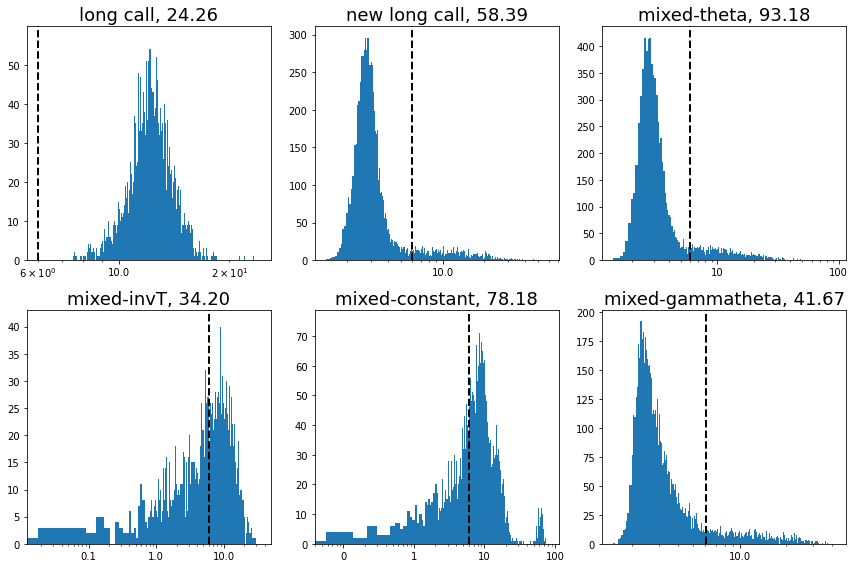

In [305]:
from matplotlib.ticker import ScalarFormatter
fig, axs = auto_subplots(len(hedge_types),figsize=(12,8))
bins = 1000

for i,ax in enumerate(axs):
    ax.hist(costs[i], bins=bins)
    ax.axvline(BS_price,color='k',linestyle="--",linewidth=2)
    
    max_loss = np.amax(costs[i])
    ax.set_title(hedge_types[i]+", {:.2f}".format(max_loss),fontsize=18)
    if i!=0 or i!=3:
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(ScalarFormatter())
fig.tight_layout()


## Deep out-of-the-money and high volatility

In [306]:
S = 10
K = 50
tau = 20./52.
sigma = 1
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  0.021638227112893788


In [307]:
hedge_types = ["long call","new long call","mixed-theta","mixed-invT","mixed-constant","mixed-gammatheta"]
costs = [[] for _ in range(len(hedge_types))]
for i in range(10000):
    Scur = 10
    strike_price = 50
    rfRate = 0.05
    sigma = 1
    T = 20./52.
    dt = (1./52.)*.25
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
    for i,price in enumerate(final_prices):
        costs[i].append(price)
    
# traditional_cost = np.array(traditional_cost)
# my_cost = np.array(my_cost)
costs = np.array(costs)
print("Averages: ",np.mean(costs,axis=1))
print("Variances: ",np.var(costs,axis=1))

Averages:  [0.02191089 0.0192568  0.04978057 0.01967722 0.06148775 0.01949663]
Variances:  [0.01612612 0.23867841 2.05643134 0.21518368 2.40360124 0.22808811]


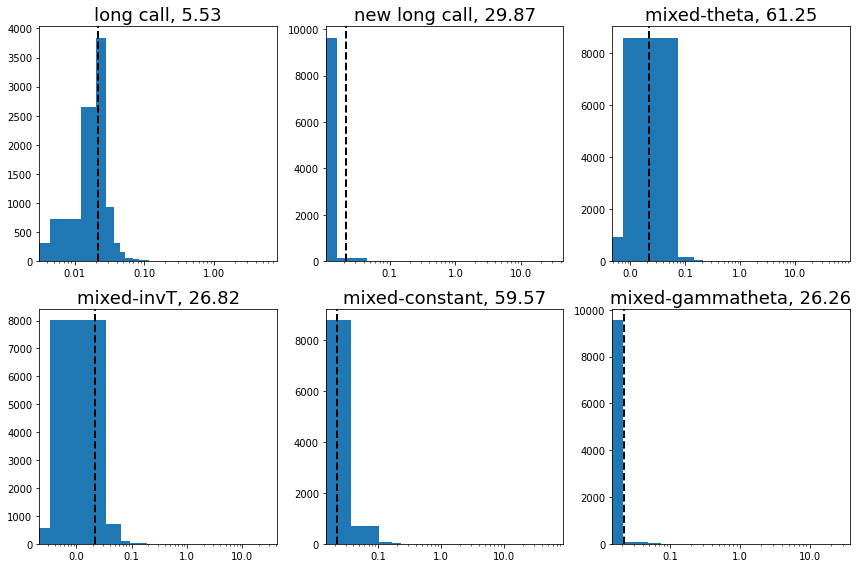

In [308]:
from matplotlib.ticker import ScalarFormatter
fig, axs = auto_subplots(len(hedge_types),figsize=(12,8))
bins = 1000

for i,ax in enumerate(axs):
    ax.hist(costs[i], bins=bins)
    ax.axvline(BS_price,color='k',linestyle="--",linewidth=2)
    
    max_loss = np.amax(costs[i])
    ax.set_title(hedge_types[i]+", {:.2f}".format(max_loss),fontsize=18)
    if i!=0 or i!=3:
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(ScalarFormatter())
fig.tight_layout()

## Deep in-the-money

In [309]:
S = 90
K = 50
tau = 20./52.
sigma = 0.1
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  40.95235188198986


In [310]:
hedge_types = ["long call","new long call","mixed-theta","mixed-invT","mixed-constant","mixed-gammatheta"]
costs = [[] for _ in range(len(hedge_types))]
for i in range(10000):
    Scur = 90
    strike_price = 50
    rfRate = 0.05
    sigma = 0.1
    T = 20./52.
    dt = (1./52.)
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
    for i,price in enumerate(final_prices):
        costs[i].append(price)
    
# traditional_cost = np.array(traditional_cost)
# my_cost = np.array(my_cost)
costs = np.array(costs)
print("Averages: ",np.mean(costs,axis=1))
print("Variances: ",np.var(costs,axis=1))

Averages:  [41.74667073 40.80311433 40.86615339 41.75121041 41.74667073 41.20512197]
Variances:  [2.01948392e-28 9.73978956e+00 9.89389713e+00 1.30080008e-28
 2.01948392e-28 3.34375873e+00]


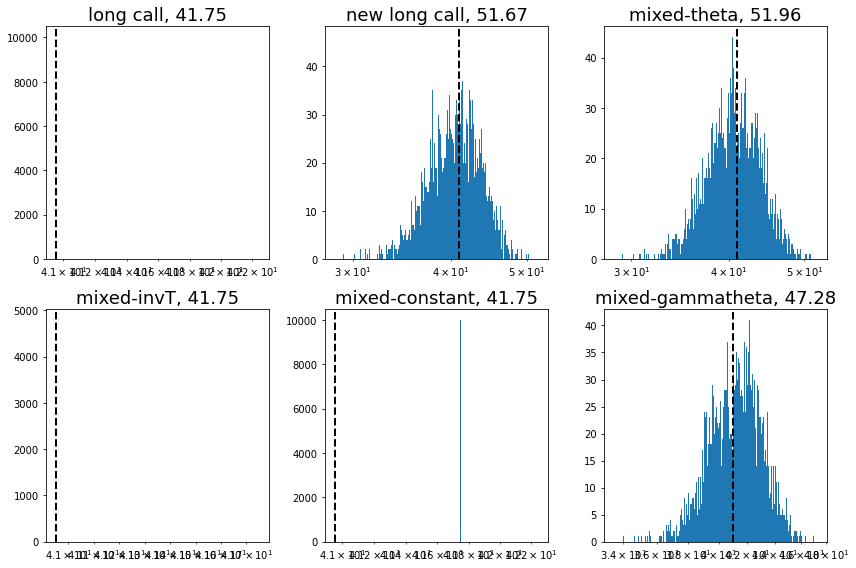

In [311]:
from matplotlib.ticker import ScalarFormatter
fig, axs = auto_subplots(len(hedge_types),figsize=(12,8))
bins = 1000

for i,ax in enumerate(axs):
    ax.hist(costs[i], bins=bins)
    ax.axvline(BS_price,color='k',linestyle="--",linewidth=2)
    
    max_loss = np.amax(costs[i])
    ax.set_title(hedge_types[i]+", {:.2f}".format(max_loss),fontsize=18)
    if i!=0 or i!=3:
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(ScalarFormatter())
fig.tight_layout()